# Homework 2
Lauren Bassett  
DS 6040

Honor Pledge: On my honor, I pledge that I have neither given nor recieved help on this assignment. 

Imports

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
from itertools import combinations

Read in Data

In [2]:
wine_testing = pd.read_csv('whitewine-testing-ds6040.csv')
wine_training = pd.read_csv('whitewine-training-ds6040.csv')

Data Exploration/Commentary

In [75]:
wine_training.wine_quality.value_counts()
wine_training.head()
training_counts = wine_training['wine_quality'].value_counts().to_frame()
total_training = training_counts.sum()[0]

3178

A few observations before we begin:  
* Since we are looking primarily at how the predictors influence the quality of wine, I wanted to highlight the types of wine quality that are being classified by the dataset. There are 3 possible outcomes: C, F, and A. 
* The training dataset has 3178 Observations


# Question 1: Linear Discriminant Analysis
## Fit LDS Classifiers
* Calculate Overall mis-classification rate 
* Present cross-tabs table showing which categories are being classified correctly vs. incorrectly. 
* For each prior, apply LDA model to the testing dataset, and present the misclassification rate and cross tabs. 


LDA Function:  
*Note: copied directly from the provided BayesClassifiers.ipynb file*

In [3]:
class LDA():
    def __init__(self, dataset, class_var, priors = None):
        n_class = len(dataset[class_var].unique())
        if priors is None:
            priors = np.repeat(1/n_class, n_class)
        self.priors =  np.asarray(priors)
        self.means = dataset.groupby(class_var).mean()
        self.sigma = dataset.cov()
        self.class_var = class_var
        self.training_data = dataset
    def predict_probs(self, data = None):
        if data is None:
            data = self.training_data
        data_temp = data.drop(self.class_var, axis = 1)
        dens_list = []
        col_names = []
        for ind, row in self.means.iterrows():
            col_names.append(ind)
            dens_list.append(multivariate_normal.pdf(data_temp, mean = np.asarray(row), cov = self.sigma))
        dens_list = pd.DataFrame(np.transpose(np.vstack(dens_list)),columns= col_names)
        dens_list = dens_list.mul(self.priors, axis=1)
        dens_list = dens_list.div(dens_list.sum(axis=1), axis=0)
        dens_list['True Class'] = data[self.class_var]
        return dens_list 
    def predict_MAP(self, data = None):        
        if data is None:
            data = self.training_data
        dens_list = self.predict_probs(data).drop('True Class', axis = 1)
        map_list = dens_list.idxmax(axis = 1)
        maps = {'MAP Class': map_list}
        maps = pd.DataFrame(maps)
        maps['True Class'] = data[self.class_var]
        return maps
    def misclass_rate(self, data = None):
        if data is None:
            data = self.training_data
        maps = self.predict_MAP(data = data)
        
        
        maps['Mis_class'] = maps['MAP Class']  == maps['True Class']
        
        mis_class =  1 - maps['Mis_class'].mean()
        
        return mis_class
    def misclass_xtabs(self, data = None):
        if data is None:
            data = self.training_data
        maps = self.predict_MAP(data = data)
        
        xtabs = pd.crosstab(maps['MAP Class'], maps['True Class'])        
        return xtabs
    def misclass_pairplot(self, data = None):
        if data is None:
            data = self.training_data
        maps = self.predict_MAP(data = data)
        temp_dat = data.copy(deep = True)
        temp_dat['Mis-Classified'] = maps['MAP Class']  != maps['True Class']
        plot = sns.pairplot(temp_dat,hue="Mis-Classified", height = 1.5, aspect = 1.5)   
        return plot
    

## a) Non-informative (flat) priors on wine quality  
For my non-informative prior, I am going to weight the likelihood of each possible outcome as 1/3, since there are 3 possible outcomes. 

In [201]:
flat_priors = [1/3, 1/3, 1/3]
LDA_non_informative = LDA(wine_training, 'wine_quality', priors = flat_priors)
print('+-----Non-Informative-Priors----+')
print('\t-Training Dataset-')
Non_Inform_Train_MCR = LDA_non_informative.misclass_rate()
print("Mis-Classification Rate:",Non_Inform_Train_MCR)
print("** Cross Tab **")
print(LDA_non_informative.misclass_xtabs())
print('----------------------------------')
print("\t-Testing Dataset-")
Non_Inform_Test_MCR = LDA_non_informative.misclass_rate(wine_testing)
print("Mis-Classification Rate:",Non_Inform_Test_MCR)
print("** Cross Tab **")
print(LDA_non_informative.misclass_xtabs(wine_testing))

+-----Non-Informative-Priors----+
	-Training Dataset-
Mis-Classification Rate: 0.49496538703587156
** Cross Tab **
True Class   A    C    F
MAP Class               
A           69  687   62
C           22  800  202
F            9  591  736
----------------------------------
	-Testing Dataset-
Mis-Classification Rate: 0.48546511627906974
** Cross Tab **
True Class   A    C    F
MAP Class               
A           56  348   43
C           15  381  149
F            9  271  448


## b) Priors that reflect the observed proportion of wines at different quality levels
For the priors here, I take the number of wines in each category in the training dataset, and divide it by the total number of wines in the training data. 

In [202]:
proportion_priors = [training_counts.wine_quality.A/total_training, training_counts.wine_quality.C/total_training, training_counts.wine_quality.F/total_training]
LDA_proportional_priors = LDA(wine_training, 'wine_quality', priors = proportion_priors)
print('+-------Proportional-Priors------+')
print('\t-Training Dataset-')
Proportional_Train_MCR = LDA_proportional_priors.misclass_rate()
print("Mis-Classification Rate:",Proportional_Train_MCR)
print("** Cross Tab **")
print(LDA_proportional_priors.misclass_xtabs())
print('----------------------------------')
print("\t-Testing Dataset-")
Proportional_Test_MCR = LDA_proportional_priors.misclass_rate(wine_testing)
print("Mis-Classification Rate:",Proportional_Test_MCR)
print("** Cross Tab **")
print(LDA_proportional_priors.misclass_xtabs(wine_testing))

+-------Proportional-Priors------+
	-Training Dataset-
Mis-Classification Rate: 0.28099433606041535
** Cross Tab **
True Class    A     C    F
MAP Class                 
A             0     0    1
C           100  1913  627
F             0   165  372
----------------------------------
	-Testing Dataset-
Mis-Classification Rate: 0.32732558139534884
** Cross Tab **
True Class   A    C    F
MAP Class               
C           79  923  406
F            1   77  234


## c) Priors that reflect the notion that most wines are awful, some wines are average, and few wines are good (your choice for the specific values)
For my priors here, I am assuming 80% of the wines are poor, 15% of the wines are average, and 5% of the wines are good. 

In [97]:
MFSCFA_priors = [0.05, 0.15,0.8]
LDA_MFSCFA = LDA(wine_training, 'wine_quality', priors = MFSCFA_priors)
print('+--Most-Awful--Some-Average--Few-Good--+')
print('\t-Training Dataset-')
MFSCFA_Train_MCR = LDA_MFSCFA.misclass_rate()
print("Mis-Classification Rate:",MFSCFA_Train_MCR)
print("** Cross Tab **")
print(LDA_MFSCFA.misclass_xtabs())
print('----------------------------------')
print("\t-Testing Dataset-")
MFSCFA_Test_MCR = LDA_MFSCFA.misclass_rate(wine_testing)
print("Mis-Classification Rate:",MFSCFA_Test_MCR)
print("** Cross Tab **")
print(LDA_MFSCFA.misclass_xtabs(wine_testing))

+--Most-Awful--Some-Average--Few-Good--+
	-Training Dataset-
Mis-Classification Rate: 0.6415984896161108
** Cross Tab **
True Class   A     C    F
MAP Class                
A           10    51    2
C           20   135    4
F           70  1892  994
----------------------------------
	-Testing Dataset-
Mis-Classification Rate: 0.5848837209302326
** Cross Tab **
True Class   A    C    F
MAP Class               
A            9   38    0
C           10   72    7
F           61  890  633


## d) Priors that somebody with a terrible taste in wine would use (most are good, few are bad or average)
For the priors here, I have 80% of the wines classified as good, where only 15% are classified as average,and 5% classified as bad.

In [95]:
bad_priors = [0.8, 0.15,0.05]
LDA_bad_taste = LDA(wine_training, 'wine_quality', priors = bad_priors)
print('+---------Bad-Sommelier--------+')
print('\t-Training Dataset-')
Bad_Taste_Train_MCR = LDA_bad_taste.misclass_rate()
print("Mis-Classification Rate:",Bad_Taste_Train_MCR)
print("** Cross Tab **")
print(LDA_bad_taste.misclass_xtabs())
print('----------------------------------')
print("\t-Testing Dataset-")
Bad_Taste_Test_MCR = LDA_bad_taste.misclass_rate(wine_testing)
print("Mis-Classification Rate:",Bad_Taste_Test_MCR)
print("** Cross Tab **")
print(LDA_bad_taste.misclass_xtabs(wine_testing))

+---------Bad-Sommelier--------+
	-Training Dataset-
Mis-Classification Rate: 0.9093769666456891
** Cross Tab **
True Class    A     C    F
MAP Class                 
A           100  1993  799
C             0    53   66
F             0    32  135
----------------------------------
	-Testing Dataset-
Mis-Classification Rate: 0.8866279069767442
** Cross Tab **
True Class   A    C    F
MAP Class               
A           79  945  518
C            1   32   38
F            0   23   84


## Conclusions

In [98]:
x_tabs = {'Training': [Non_Inform_Train_MCR, Proportional_Train_MCR, MFSCFA_Train_MCR, Bad_Taste_Train_MCR],
            'Testing':[Non_Inform_Test_MCR, Proportional_Test_MCR, MFSCFA_Test_MCR, Bad_Taste_Test_MCR]}

pd.DataFrame(x_tabs, index=['Non Informed','Proportional', 'Good Taste', 'Bad Taste'])

,Training,Testing
Non Informed,0.494965,0.485465
Proportional,0.280994,0.327326
Good Taste,0.641598,0.584884
Bad Taste,0.909377,0.886628


### Discuss the performance of your LDA models under your various choice of priors:  

The four different LDA Models vary in their misclassification rates. 
The model using proportional priors outperformed the other models, with roughly 30% of the data being misclassified.   
The model that used the non-informed priors was the second-best, but roughly half of the data was misclassified.  
The model where most of the wines were classified as poor performs third best, with 64% of the training data and 58% of the testing data being misclassified. 
The model representing someone with a bad taste in wine misclassified nearly all of the data. What I find interesting is that I used mirrored proportions for the Good and Bad Taste, and the 'Good Taste' Classification still does not perform well, even though the 'Bad Taste' model is misclassifying almost all data points.  

The classes of wine quality are greatly unbalanced, so I would recommend using the proportion as priors. As shown, this allows the model to better handle the unbalanced classes and more accurately predict the correct classifications. 

### How does the performance change when we start testing our models on the testing data?  
For the uninformed, good, and bad taste priors, the accuracy of the model increases when we use the testing data. For the proportional data, the accuracy of the model decreases.  
I believe this occurs because the proportions used for the priors are directly tied to the training data, the proportions are not the same in the testing data, whereas the other priors do not rely explicitly on a metric from the training data. However, these priors still greatly outperform the other models. 

# Question 2
Fit LDA models for each combination of three features, there will be 165 combinations. Use flat priors on wine quality. 

### a)

For each model, extract the overall mis-classification for both the training and testing dataset. This gets reused in B, so I made it a function:


In [198]:
#Create List of all possible combinations of 3 features
def find_three_combo(priors):
    combo_of_three_features = [list(x) for x in combinations(wine_training.drop('wine_quality', axis=1), 3)]

    LDA_train_results = []
    LDA_test_results = []

    #Iterate through all possible combinations of three. 
    for combination in combo_of_three_features:
        current_columns = combination + ['wine_quality']
        train_three_feat = wine_training[current_columns]
        test_three_feat = wine_testing[current_columns]
        #print(train_three_feat)
        LDA_3 = LDA(train_three_feat, 'wine_quality', priors=priors)
        train_misclass = LDA_3.misclass_rate()
        test_misclass = LDA_3.misclass_rate(test_three_feat)
        LDA_train_results.append((current_columns, train_misclass))
        LDA_test_results.append((current_columns, test_misclass))

    return(LDA_train_results, LDA_test_results)
 

Which combination of three features provides the lowest mis-classification rate for the testing and training datasets? Are they the same or different? 

In [203]:
LDA_train, LDA_test = find_three_combo(priors=flat_priors)
train_final = pd.DataFrame(LDA_train, columns = ['Combination', 'Misclass_Rate'])
test_final = pd.DataFrame(LDA_test, columns = ['Combination', 'Misclass_Rate'])
train_min = pd.DataFrame(train_final[train_final.Misclass_Rate == train_final.Misclass_Rate.min()]).reset_index()
print("Training:\nThe Combination of Features that Provides the lowest mis-class rate, and the corresponding rate is...\n", train_min)
print()
test_min = pd.DataFrame(test_final[test_final.Misclass_Rate == test_final.Misclass_Rate.min()]).reset_index()
print("Testing:\nThe Combination of Features that Provides the lowest mis-class rate, and the corresponding rate is...\n", test_min)

Training:
The Combination of Features that Provides the lowest mis-class rate, and the corresponding rate is...
    index                                        Combination  Misclass_Rate
0     59  [volatile.acidity, residual.sugar, alcohol, wi...       0.505035

Testing:
The Combination of Features that Provides the lowest mis-class rate, and the corresponding rate is...
    index                                        Combination  Misclass_Rate
0     77  [volatile.acidity, density, alcohol, wine_qual...       0.487791


The feature combinations that create the lowest misclass rate for the training and the testing data are very similar. The only difference is that the training data has residual sugar, where the testing data uses density. Otherwise, both the other features are volatile acidity and alcohol. 
  
Using the functions provided, provide pair plots for mis-classifications.

In [191]:
LDA_best_misclass_train = LDA(wine_training[train_min['Combination'][0]], 'wine_quality', priors=flat_priors)
LDA_best_misclass_test = LDA(wine_testing[test_min['Combination'][0]], 'wine_quality', priors=flat_priors)

Training Data:

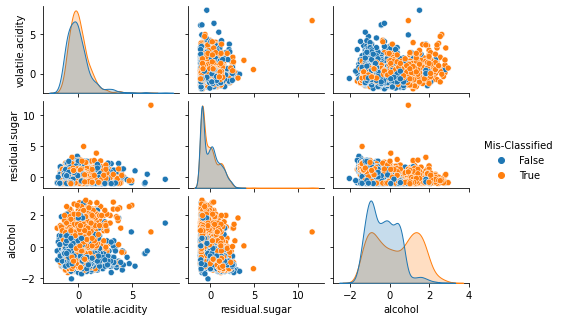

In [197]:
LDA_best_misclass_train.misclass_pairplot()

Testing Data:


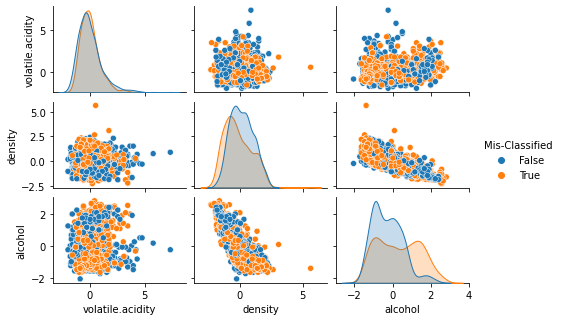

In [196]:
LDA_best_misclass_test.misclass_pairplot()

## b) Using priors that observed proportion of wine quality in the training dataset, identify the combination of three features that provide the lowest misclassification rate. 

In [206]:
LDA_train, LDA_test = find_three_combo(priors=proportion_priors)
train_final = pd.DataFrame(LDA_train, columns = ['Combination', 'Misclass_Rate'])
test_final = pd.DataFrame(LDA_test, columns = ['Combination', 'Misclass_Rate'])
train_min = pd.DataFrame(train_final[train_final.Misclass_Rate == train_final.Misclass_Rate.min()]).reset_index()
print("Training:\nThe Combination of Features that Provides the lowest mis-class rate, and the corresponding rate is...\n", train_min)
print()
test_min = pd.DataFrame(test_final[test_final.Misclass_Rate == test_final.Misclass_Rate.min()]).reset_index()
print("Testing:\nThe Combination of Features that Provides the lowest mis-class rate, and the corresponding rate is...\n", test_min)
LDA_best_misclass_train = LDA(wine_training[train_min['Combination'][0]], 'wine_quality', priors=proportion_priors)
LDA_best_misclass_test = LDA(wine_testing[test_min['Combination'][0]], 'wine_quality', priors=proportion_priors)

Training:
The Combination of Features that Provides the lowest mis-class rate, and the corresponding rate is...
    index                                        Combination  Misclass_Rate
0     80  [volatile.acidity, sulphates, alcohol, wine_qu...        0.28005

Testing:
The Combination of Features that Provides the lowest mis-class rate, and the corresponding rate is...
    index                                        Combination  Misclass_Rate
0     59  [volatile.acidity, residual.sugar, alcohol, wi...       0.329651


Training:

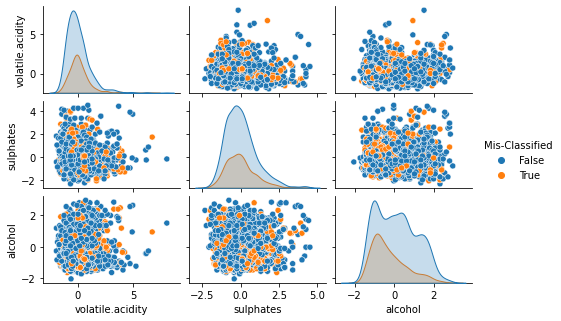

In [207]:
LDA_best_misclass_train.misclass_pairplot()

Testing:

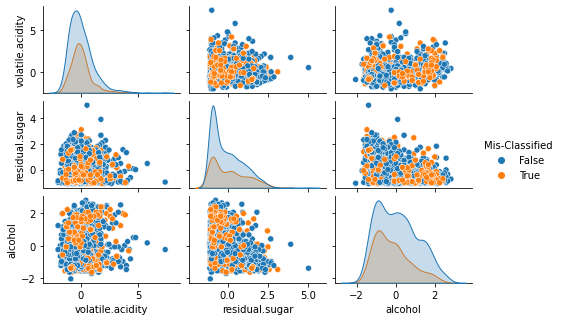

In [208]:
LDA_best_misclass_test.misclass_pairplot()

Do the best models differ from when you used flat priors?
Yes, but again, only very slightly. When using flat priors, the best training model used volitile acidity, residual sugar, and alcohol. Using proportional priors, the best model uses volitile acidity,sulphates, and alcohol.
Using flat priors, the best testing model used volitile acidity, density, and alcohol, and the proportional priors best model uses volitile acidity, residual sugar, and alcohol. 

Again, it is only one measure that changes. 

The best model for the flat prior training model is equivalent to the best model for proprortional priors testing model. 

The mis-classification rate is much lower for the proportional priors model. 
